In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import scipy.io

In [2]:
# Settings
input_path = os.path.join('../input/chiu-2015/2015_BOE_Chiu')
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 284
height = 284
width_out = 196
height_out = 196

subject_path

['../input/chiu-2015/2015_BOE_Chiu/Subject_01.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_02.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_03.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_04.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_05.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_06.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_07.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_08.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_09.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_10.mat']

### Data Visualization

In [3]:
mat = scipy.io.loadmat(subject_path[0])
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

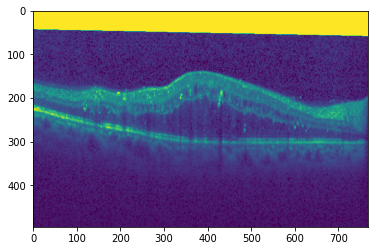

In [4]:
plt.imshow(img_array[25])

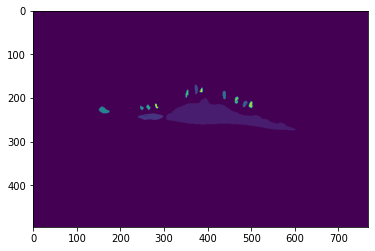

In [5]:
plt.imshow(manual_fluid_array[25])

In [6]:
def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

In [7]:
thresh = np.vectorize(thresh, otypes=[np.float])

In [8]:
subject_path

['../input/chiu-2015/2015_BOE_Chiu/Subject_01.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_02.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_03.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_04.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_05.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_06.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_07.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_08.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_09.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_10.mat']

In [9]:
subject_path[:9]

['../input/chiu-2015/2015_BOE_Chiu/Subject_01.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_02.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_03.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_04.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_05.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_06.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_07.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_08.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_09.mat']

In [10]:
def create_dataset(paths):
    x = []
    y = []
    
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255
        img_array = resize(img_array, (img_array.shape[0], width, height))
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        fluid_array  = resize(fluid_array, (fluid_array .shape[0], width_out, height_out))

        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 0)]
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(subject_path[:9])
x_val, y_val = create_dataset(subject_path[9:])

100%|██████████| 1/1 [00:12<00:00, 12.35s/it]


In [11]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 1, 284, 284), (99, 1, 196, 196), (11, 1, 284, 284), (11, 1, 196, 196))

### UNet

In [12]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
use_gpu = torch.cuda.is_available()

In [13]:
batch_size = 9
epochs = 100
epoch_lapse = 20
threshold = 0.5
sample_size = None

In [14]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
    union = K.sum(y_true,[1,2])+K.sum(y_pred,[1,2])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    dice = K.mean((2 * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [16]:
# standard unet, 3 down-samples
f_size = 5
pad= int((f_size-1)/2)
channels = [32, 64, 128, 256]


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        
        self.relu = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x
    
class UNET_Model1(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        # pooling
        self.pool = torch.nn.MaxPool2d(kernel_size=2)
        
        # ENCODER

        # block 00 (down)
        self.conv00 = ConvBlock(1, channels[0])
        # block 10 (down)
        self.conv10 = ConvBlock(channels[0], channels[1])
        # block 20 (down)
        self.conv20 = ConvBlock(channels[1],channels[2])
        # block 30 (down)
        self.conv30 = ConvBlock(channels[2],channels[3])
        
        # DECODER
        
        # block 22 (up)
        self.upconv22 = torch.nn.ConvTranspose2d(channels[3],channels[2], kernel_size=10, stride=2)
        self.conv22 = ConvBlock(2*channels[2],channels[2])
        # block 13 (up)
        self.upconv13 = nn.ConvTranspose2d(channels[2],channels[1],kernel_size=18,stride=2)
        self.conv13 = ConvBlock(2*channels[1],channels[1])
        # block 04 (up)
        self.upconv04 = nn.ConvTranspose2d(channels[1],channels[0],kernel_size=18,stride=2)
        self.conv04 = ConvBlock(2*channels[0],channels[0])
        
        # final layers
        self.final04 = nn.Conv2d(channels[0],2,kernel_size=81)
        
    def forward(self, x):
        
        # Encoder Path
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x = self.conv30(self.pool(x20))
        
        # Up-sampling second round
        x = self.upconv22(x)
        x = self.conv22(torch.cat((x20,x),dim=1))
        del x20
        
        # Up-sampling third round
        x = self.upconv13(x)
        x = self.conv13(torch.cat((x10,x),dim=1))
        del x10
        
        # Final up-sample
        x = self.upconv04(x)
        x = self.conv04(torch.cat((x00,x),dim=1))
        del x00
        
        # Outputs
        x = self.final04(x)
        
        return x
    
batch_train_x = torch.from_numpy(x_train[0 * batch_size : (0 + 1) * batch_size]).float()
batch_train_y = torch.from_numpy(y_train[0 * batch_size : (0 + 1) * batch_size]).long()

unet1 = UNET_Model1()
unet1 = unet1.cuda()
unet1(batch_train_x.cuda()).shape

#device = torch.device(5)
#model = model.to(device)

torch.Size([9, 2, 196, 196])

In [19]:
def train_step(inputs, labels, optimizer, criterion, model):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(batch_size*width_out*height_out, 2)
    labels = labels.resize(batch_size*width_out*height_out)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

## Different Models to Train

In [33]:
learning_rate = 0.01
unet1 = UNET_Model1()
if use_gpu:
    unet1 = unet1.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet1.parameters(), lr = 0.01, momentum=0.99)

In [22]:
def get_val_loss(x_val, y_val, model):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = model(x_val)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [25]:
def get_val_metric(x_val, y_val, func, model): 
    model.eval()
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = model(x_val)
    y_val_adj = np.transpose(y_val.cpu().detach().numpy(), (0, 2,3,1))[:, :,:,0]
    return func(torch.tensor(y_val_adj), outputs.argmax(1).cpu().detach().numpy())

In [28]:
def training_loop(model):
    epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
    t = trange(epochs, leave=True)
    for _ in t:
        total_loss = 0
        for i in range(epoch_iter):
            batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
            batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
            if use_gpu:
                batch_train_x = batch_train_x.cuda()
                batch_train_y = batch_train_y.cuda()
            batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion, model)
            total_loss += batch_loss
        if (_+1) % epoch_lapse == 0:
            val_loss = get_val_loss(x_val, y_val, model)
            print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

In [35]:
training_loop(unet1)

 20%|██        | 20/100 [19:13<1:20:27, 60.34s/it]

Total loss in epoch 20 : 0.6825032234191895 and validation loss : 0.5243110656738281


 40%|████      | 40/100 [38:26<1:00:20, 60.35s/it]

Total loss in epoch 40 : 0.6738932728767395 and validation loss : 0.4859837293624878


 60%|██████    | 60/100 [57:39<40:13, 60.35s/it]  

Total loss in epoch 60 : 0.6740543246269226 and validation loss : 0.5159845352172852


 80%|████████  | 80/100 [1:16:53<20:07, 60.35s/it]

Total loss in epoch 80 : 0.6743324995040894 and validation loss : 0.5030625462532043


100%|██████████| 100/100 [1:36:06<00:00, 57.67s/it]

Total loss in epoch 100 : 0.6740502119064331 and validation loss : 0.5070443153381348


## Check Metrics

In [37]:
validation_iou = get_val_metric(x_val, y_val, iou_coef, unet1)
validation_dice_coef = get_val_metric(x_val, y_val, dice_coef, unet1)

In [38]:
print(f"For this particular model, got an IOU = {validation_iou} and Dice Coefficient = {validation_dice_coef}")

For this particular model, got an IOU = 0.2098794794232891 and Dice Coefficient = 0.2098794794232891
